# Introduction 


I came across this post of **Nicola Rennie** on BlueSky: 

https://bsky.app/profile/nrennie.bsky.social/post/3m3mucditmc2o

where she took a look at the sunshine hours in Leuchars-UK and produced this nice #dataviz plot. 

I decided to do the same plot, but for some places in Germany and in Brazil. Also, I reproduced this plot using Python/matplotlib. 


# Data

### @ Brazil

The data was available at the website of the [Instituto Nacional de Metereologia](https://portal.inmet.gov.br/). Following the path:
> Dados Metereológicos &rarr; Banco de Dados Metereológicos   

where is given different options of downloads. For historic data, I have filled out the form to receive the desired dataset by email. The query I've filled out for the download had the following configuration:


> **Data Inicio:** 01/01/1990 
>
> **Data Fim:** 22/10/2015
>
> **Variáveis:**
> - INSOLACAO TOTAL, DIARIO
> - PRECIPITACAO TOTAL, DIARIO
> - TEMPERATURA MEDIA COMPENSADA, DIARIA
>
> **Estações:**
> - ITAPERUNA (83695) - [RJ]

I've tried many metereological stations in Rio de Janeiro, but only Itaperuna had the daily record of sunshine. The columns I've used are:

* `Data Medicao`: measurement date
* `INSOLACAO TOTAL, DIARIO(h)`: duration of sunlight, in hours  

from the file `dados_83695_D_1990-01-01_2025-10-22.csv` at the directory `dados_ItaperunaRJ_1990-2025`.

### @ Germany

The data that I wanted was available at the website of the [Deustcher Wetterdienst - DWD](www.dwd.de). Following my intuition with some of my German language knowledge, I got to the page of the Climate Data Center (CDC), which offer open acess data from the DWD. Follow this path:    

> Startseite &rarr; Klima und Umwelt &rarr; Klima-Webdienste &rarr; CDC (Climate Data Center)

I then used the [HTTPS address](https://opendata.dwd.de/climate_environment/CDC/) to reach to the daily data for the solar information:

`https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/solar/`  

By reading the description pdf, I then found the columns I need:

* `STATIONS_ID`: DWD Station ID
* `MESS_DATUM`: reference date for the measurement (in format YYYYMMDD)
* `SD_STRAHL`: the daily sum of sunshine duration (in hours) 

from the files `produkt_st_tag*.txt` in the following directories:

* `tageswerte_ST_04642_row` (Seehausen, next to Magdeburg)
* `tageswerte_ST_01975_row` (Hamburg)
* `tageswerte_ST_15000_row` (Aachen)
* `tageswerte_ST_03987_row` (Potsdam)

Note: on CDC page, this files are updated daily. 

**Disclaimer:**
* 1) I have not tried to perform any quality filtering, particularly, in the DWD dataset which seems to provide this possibility with the parameter `QN_592`. Please, read the decription pdf for more information.
* 2) For the daily rows with `null` or `nan` values, instead of remove them, I have replaced them for the average value of the respective month. 

In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
from io import BytesIO

In [2]:
# functions for analysis and plot
def get_monthly_means_and_climatology(df, datakey):
    
    if datakey=='dwd':
        
        # convert MESS_DATUM to datetime
        df["MESS_DATUM"] = pd.to_datetime(df["MESS_DATUM"], format="%Y%m%d")
        
        # make sure MESS_DATUM is datetime and Month extracted
        df["MESS_DATUM"] = pd.to_datetime(df["MESS_DATUM"], errors="coerce")
        df["Month"] = df["MESS_DATUM"].dt.month
        
        # convert SD_STRAHL to numeric, forcing invalids to NaN
        df["SD_STRAHL"] = pd.to_numeric(df["SD_STRAHL"], errors="coerce")

        # replace all placeholder -999.0 with NaN
        df["SD_STRAHL"] = df["SD_STRAHL"].replace(-999.0, np.nan)
        
        # compute per-month mean (ignoring NaN)
        monthly_avg = df.groupby("Month")["SD_STRAHL"].mean()
        
        # replace missing values (NaN) with corresponding monthly mean
        df["SD_STRAHL"] = df["SD_STRAHL"].fillna(df["Month"].map(monthly_avg))
        
        # extract Year and Month for grouping
        df["Year"] = df["MESS_DATUM"].dt.year
        df["Month"] = df["MESS_DATUM"].dt.month
        df["MonthName"] = df["MESS_DATUM"].dt.strftime("%B")
        
        # compute monthly mean per year per station
        monthly_means = (
            df.groupby(["STATIONS_ID", "Year", "Month", "MonthName"], as_index=False).mean(numeric_only=True)
        )
        
        # compute climatological monthly mean (average across all years)
        climatology = (
            monthly_means.groupby(["STATIONS_ID", "Month", "MonthName"], as_index=False).mean(numeric_only=True)
        )
        # sort by month (January → December)
        climatology = climatology.sort_values("Month").reset_index(drop=True)

    elif datakey=='inmet':
        
        # remove extra column and add placeholder for station id
        df = df.drop('Unnamed: 4', axis=1)
        df["id_estacao"] = 9999 
        
        # make sure 'Data Medicao' is datetime and Month extracted
        df["Data Medicao"] = pd.to_datetime(df["Data Medicao"], errors="coerce")
        df["Month"] = df["Data Medicao"].dt.month
        
        # convert 'INSOLACAO TOTAL, DIARIO(h)' to numeric, forcing invalids to NaN
        df["INSOLACAO TOTAL, DIARIO(h)"] = pd.to_numeric(df["INSOLACAO TOTAL, DIARIO(h)"], errors="coerce")
        
        # compute per-month mean (ignoring NaN)
        monthly_avg = df.groupby("Month")["INSOLACAO TOTAL, DIARIO(h)"].mean()
        
        # replace missing values (NaN) with corresponding monthly mean
        df["INSOLACAO TOTAL, DIARIO(h)"] = df["INSOLACAO TOTAL, DIARIO(h)"].fillna(df["Month"].map(monthly_avg))
        
        # extract Year and Month for grouping
        df["Year"] = df["Data Medicao"].dt.year
        df["Month"] = df["Data Medicao"].dt.month
        df["MonthName"] = df["Data Medicao"].dt.strftime("%B")
        
        # compute monthly mean per year per station
        monthly_means = (
            df.groupby(["id_estacao", "Year", "Month", "MonthName"], as_index=False).mean(numeric_only=True)
        )
        
        # compute climatological monthly mean (average across all years)
        climatology = (
            monthly_means.groupby(["id_estacao", "Month", "MonthName"], as_index=False).mean(numeric_only=True)
        )
          
    return monthly_means, climatology    

# open an image from the Internet, from https://python-graph-gallery.com/513-add-logo-matplotlib/
def open_image_internet(url_adress):
    
    # send http request to the url adress
    response = requests.get(url_adress) 
    
    # make sure everything went right
    if response.status_code == 200:
        image_bytes = BytesIO(response.content) # get content 
        image = Image.open(image_bytes) # open the image
        return image # output
    else:
        print("Failed to download image:", response.status_code)

def sunshine_plot(monthly_means, climatology, datakey, sunkey, tlabel, toptext, icon, savename):
    
    plt.figure(figsize=(10, 8)) #10x8

    # plot vertical lines for each year (barcode style)
    for _, row in monthly_means.iterrows():
        plt.vlines(
            x = row[sunkey],
            ymin = row["Month"] - 0.4,
            ymax = row["Month"] + 0.4,
            color = "gray",
            alpha = 0.6,
            linewidth = 0.8
        )

    # plot vertical lines for each month average over the years 
    for _, row in climatology.iterrows():
        plt.vlines(
        x = row[sunkey],
        ymin = row["Month"] - 0.4,
        ymax = row["Month"] + 0.4,
        color = "k",
        linewidth = 2.5
        )
    
    # adding month names in Y-axis
    months = np.arange(1, 13)
    plt.yticks(months, [pd.to_datetime(str(m), format="%m").strftime("%B") for m in months], 
               fontweight='bold',
               fontsize='x-large')
    
    # adding horizontal white lines between months for visual division
    for y in range(1, 12):  # between each month (1–11)
        plt.axhline(y + 0.5, color="white", linestyle="-", linewidth=3.5)
        
    # adding vertical padding so spacing above January and below December is equal
    plt.ylim(0.5, 12.5)
    
    # labels, title and top text
    plt.xlabel("Average hours of sunshine per day", 
               loc='right', 
               fontname='Avenir',
               fontsize='x-large', 
               fontweight='light')
    plt.title("Sunshine in "+tlabel, 
              fontname='Times New Roman', 
              fontsize=28, 
              weight='bold', 
              x=-0.15, 
              ha='left', 
              pad=50)
    plt.text(-2.1, 0.3, toptext, 
             fontsize=15, 
             fontname='Avenir', 
             weight='light')

    # inverting Y-axis, needs to be done here
    plt.gca().invert_yaxis()
    
    # remove ticks markers but show tick labels
    plt.tick_params(axis=u'both', which=u'both',length=0)

    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.xticks(fontname='Avenir', fontsize='x-large', weight='light')
    
    # add background coloring
    plt.xticks(np.arange(0, 15, 3.5))
    plt.xlim(0.0, 14.0)
    plt.axvspan(0, 3.49, color='oldlace')
    plt.axvspan(3.5, 6.99, color='papayawhip')
    plt.axvspan(7.0, 10.49, color='bisque')
    plt.axvspan(10.5, 14.0, color='navajowhite')

    # adding credit lines 
    plt.text(-0.15, -0.065, r"$\bf{Data:}$ ",
             transform=plt.gca().transAxes, 
             fontsize=12, 
             fontname='Arial', 
             #weight='bold', 
             va='center')
    
    if datakey=='dwd': 
        dname='dwd.de'
    elif datakey=='inmet':
        dname='inmet.gov.br'
        
    plt.text(-0.075, -0.065, dname, 
             transform=plt.gca().transAxes,
             fontsize=12, 
             fontname='Arial', 
             weight='light', 
             va='center')
    
    plt.text(-0.15, -0.11, r"$\bf{Graphic:}$ ", 
             transform=plt.gca().transAxes, 
             fontsize=12, 
             fontname='Arial', 
             weight='bold', 
             va='center')
    
    # convert to RGB before array conversion
    logo_array = np.array(icon.convert("RGB"))
    
    # create an OffsetImage with desired zoom level
    imbox = OffsetImage(logo_array, zoom=0.04)
    ab = AnnotationBbox(imbox, (-0.025, -0.11), 
                        xycoords='axes fraction', 
                        fontsize=0.5, 
                        frameon=False)
    plt.gca().add_artist(ab)
  
    plt.text(-0.0001, -0.11, "MariaElidaiana", 
             transform=plt.gca().transAxes, 
             fontsize=12, 
             fontname='Avenir', 
             weight='bold', 
             va='center')
    
    plt.text(-0.15, -0.16, r"$\bf{Original:}$ @nrennie.bsky.social", 
             transform=plt.gca().transAxes, 
             fontsize=12, 
             fontname='Arial', 
             #weight='bold', 
             va='center')   

    plt.gca().set_frame_on(False)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(savename, dpi=300, bbox_inches='tight', pad_inches=0.5)      

# Itaperuna - Rio de Janeiro/Brazil

In [3]:
# get data
dir1 = 'data/inmet-br/dados_ItaperunaRJ_1990-2025/'
df1 = pd.read_csv(dir1+'dados_83695_D_1990-01-01_2025-10-22.csv', sep=';', skiprows=10)
df1.head()

,Data Medicao,"INSOLACAO TOTAL, DIARIO(h)","PRECIPITACAO TOTAL, DIARIO(mm)","TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)",Unnamed: 4
0,1990-01-01,0.0,NaN,26.6,NaN
1,1990-01-02,1.3,NaN,26.8,NaN
2,1990-01-03,1.6,NaN,26.7,NaN
3,1990-01-04,9.0,NaN,26.8,NaN
4,1990-01-05,11.1,NaN,27.3,NaN


In [4]:
# get the means
dkey1 = 'inmet'
monthly_means1, climatology1 = get_monthly_means_and_climatology(df1, dkey1)

In [5]:
monthly_means1.head()

,id_estacao,Year,Month,MonthName,"INSOLACAO TOTAL, DIARIO(h)","PRECIPITACAO TOTAL, DIARIO(mm)","TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)"
0,9999,1990,1,January,9.903226,NaN,28.209677
1,9999,1990,2,February,8.467857,NaN,27.628571
2,9999,1990,3,March,8.087097,NaN,27.638710
3,9999,1990,4,April,7.548997,NaN,26.640000
4,9999,1990,5,May,7.364516,NaN,22.196774


In [6]:
climatology1.head()

,id_estacao,Month,MonthName,Year,"INSOLACAO TOTAL, DIARIO(h)","PRECIPITACAO TOTAL, DIARIO(mm)","TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)"
0,9999,1,January,2007.5,7.016793,6.072201,26.958535
1,9999,2,February,2007.5,7.631484,4.623324,27.148850
2,9999,3,March,2007.5,6.782571,5.354522,26.409546
3,9999,4,April,2007.5,6.569924,2.429114,24.953084
4,9999,5,May,2007.5,6.182948,1.190967,22.361145


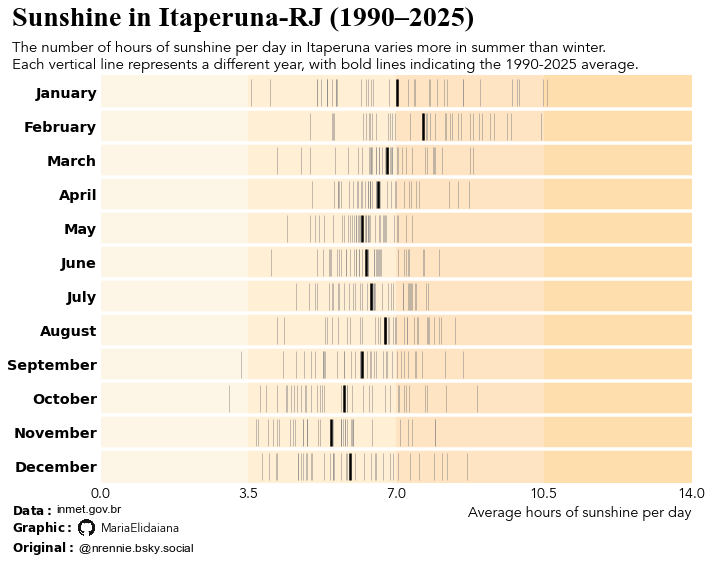

In [7]:
skey1 = 'INSOLACAO TOTAL, DIARIO(h)'  
tlabel1 = 'Itaperuna-RJ (1990–2025)'
toptext1 = """The number of hours of sunshine per day in Itaperuna varies more in summer than winter. 
Each vertical line represents a different year, with bold lines indicating the 1990-2025 average."""
icon = open_image_internet('https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png')
savename1 = 'sunshine_itaperunaRJ_1990-2025.png'

sunshine_plot(monthly_means1, climatology1, dkey1, skey1, tlabel1, toptext1, icon, savename1)

# Seehausen - Saxen-Anhalt/Germany

In [8]:
dir2 = 'data/dwd-de/tageswerte_ST_04642_row/'
df2 = pd.read_csv(dir2+'produkt_st_tag_19910101_20250930_04642.txt', sep=';')
df2.head()

,STATIONS_ID,MESS_DATUM,QN_592,ATMO_STRAHL,FD_STRAHL,FG_STRAHL,SD_STRAHL,eor
0,4642,19910101,1,-999.0,-999.0,-999.0,2.5,eor
1,4642,19910102,1,-999.0,-999.0,-999.0,0.0,eor
2,4642,19910103,1,-999.0,-999.0,-999.0,3.0,eor
3,4642,19910104,1,-999.0,-999.0,-999.0,0.4,eor
4,4642,19910105,1,-999.0,-999.0,-999.0,4.0,eor


In [9]:
dkey2 = 'dwd'
monthly_means2, climatology2 = get_monthly_means_and_climatology(df2, dkey2)

In [10]:
monthly_means2.head()

,STATIONS_ID,Year,Month,MonthName,QN_592,ATMO_STRAHL,FD_STRAHL,FG_STRAHL,SD_STRAHL
0,4642,1991,1,January,1,-999.0,-999.0,-999.0,1.929032
1,4642,1991,2,February,1,-999.0,-999.0,-999.0,2.285714
2,4642,1991,3,March,1,-999.0,-999.0,-999.0,3.461290
3,4642,1991,4,April,1,-999.0,-999.0,-999.0,6.213333
4,4642,1991,5,May,1,-999.0,-999.0,-999.0,5.990323


In [11]:
climatology2.head()

,STATIONS_ID,Month,MonthName,Year,QN_592,ATMO_STRAHL,FD_STRAHL,FG_STRAHL,SD_STRAHL
0,4642,1,January,2007.529412,1.0,-729.428843,-330.946869,136.647059,1.506010
1,4642,2,February,2007.529412,1.0,-746.142857,-251.683642,347.405933,2.611830
2,4642,3,March,2008.000000,1.0,-783.190783,-142.432258,673.072811,4.139821
3,4642,4,April,2008.000000,1.0,-885.194286,-25.712381,1231.747619,6.401221
4,4642,5,May,2008.000000,1.0,-831.671889,84.502304,1536.165899,7.501179


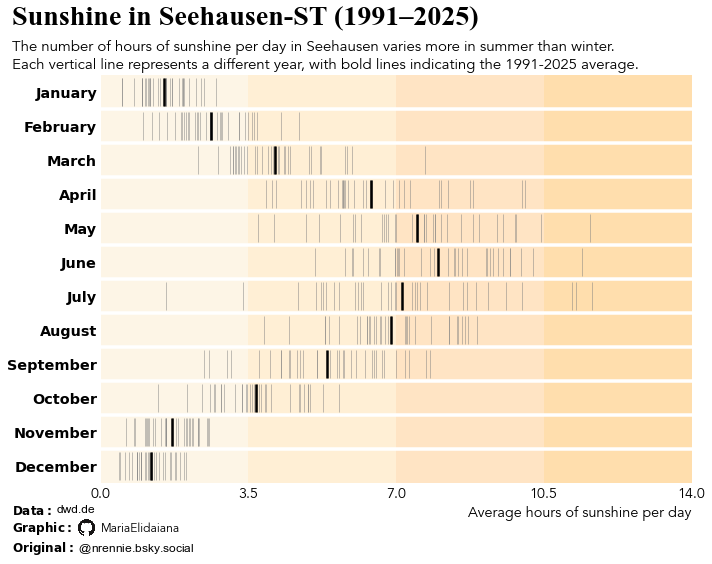

In [12]:
skey2 = 'SD_STRAHL'  
tlabel2 = 'Seehausen-ST (1991–2025)'
toptext2 = """The number of hours of sunshine per day in Seehausen varies more in summer than winter. 
Each vertical line represents a different year, with bold lines indicating the 1991-2025 average."""
icon = open_image_internet('https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png')
savename2 = 'sunshine_seehausenST_1991-2025.png'

sunshine_plot(monthly_means2, climatology2, dkey2, skey2, tlabel2, toptext2, icon, savename2)

# Hamburg - HH/Germany

In [13]:
dir3 = 'data/dwd-de/tageswerte_ST_01975_row/'
df3 = pd.read_csv(dir3+'produkt_st_tag_20050101_20250930_01975.txt', sep=';')
df3.head()

,STATIONS_ID,MESS_DATUM,QN_592,ATMO_STRAHL,FD_STRAHL,FG_STRAHL,SD_STRAHL,eor
0,1975,20050101,1,2738.0,132.0,136.0,0.2,eor
1,1975,20050102,1,2606.0,210.0,248.0,2.2,eor
2,1975,20050103,1,2769.0,135.0,144.0,0.7,eor
3,1975,20050104,1,2966.0,66.0,66.0,0.0,eor
4,1975,20050105,1,2602.0,158.0,158.0,0.0,eor


In [14]:
dkey3 = 'dwd'
monthly_means3, climatology3 = get_monthly_means_and_climatology(df3, dkey3)

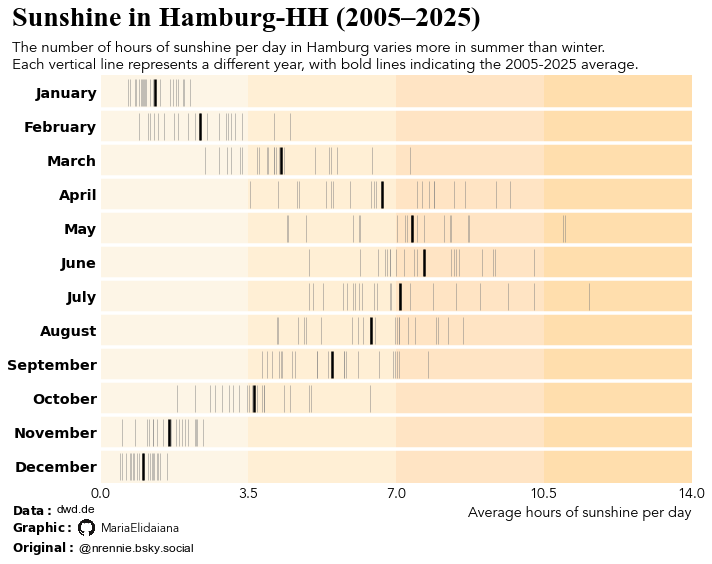

In [15]:
skey3 = 'SD_STRAHL'  
tlabel3 = 'Hamburg-HH (2005–2025)'
toptext3 = """The number of hours of sunshine per day in Hamburg varies more in summer than winter. 
Each vertical line represents a different year, with bold lines indicating the 2005-2025 average."""
savename3 = 'sunshine_hamburgHH_2005-2025.png'

sunshine_plot(monthly_means3, climatology3, dkey3, skey3, tlabel3, toptext3, icon, savename3)

# Aachen - Nordrhein-Westfalen/Germany

In [16]:
dir4 = 'data/dwd-de/tageswerte_ST_15000_row/'
df4 = pd.read_csv(dir4+'produkt_st_tag_20230101_20250930_15000.txt', sep=';')
df4.head()

,STATIONS_ID,MESS_DATUM,QN_592,ATMO_STRAHL,FD_STRAHL,FG_STRAHL,SD_STRAHL,eor
0,15000,20230101,1,-999.0,148.0,148.0,0.0,eor
1,15000,20230102,1,-999.0,107.0,107.0,0.0,eor
2,15000,20230103,1,-999.0,192.0,291.0,2.7,eor
3,15000,20230104,1,-999.0,78.0,78.0,0.0,eor
4,15000,20230105,1,-999.0,166.0,167.0,0.1,eor


In [17]:
dkey4 = 'dwd'
monthly_means4, climatology4 = get_monthly_means_and_climatology(df4, dkey4)

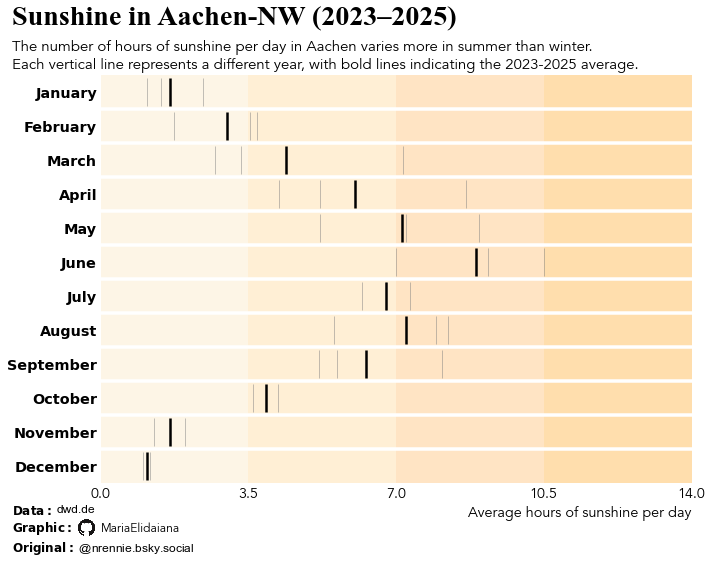

In [18]:
skey4 = 'SD_STRAHL'  
tlabel4 = 'Aachen-NW (2023–2025)'
toptext4 = """The number of hours of sunshine per day in Aachen varies more in summer than winter. 
Each vertical line represents a different year, with bold lines indicating the 2023-2025 average."""
savename4 = 'sunshine_aachenNW_2023-2025.png'

sunshine_plot(monthly_means4, climatology4, dkey4, skey4, tlabel4, toptext4, icon, savename4)

# Potsdam - Brandenburg/Germany

In [19]:
dir5 = 'data/dwd-de/tageswerte_ST_03987_row/'
df5 = pd.read_csv(dir5+'produkt_st_tag_19451231_20250930_03987.txt', sep=';')
df5.head()

,STATIONS_ID,MESS_DATUM,QN_592,ATMO_STRAHL,FD_STRAHL,FG_STRAHL,SD_STRAHL,eor
0,3987,19451231,1,-999.0,-999.0,-999.0,-999.0,eor
1,3987,19460101,1,-999.0,-999.0,-999.0,1.3,eor
2,3987,19460102,1,-999.0,-999.0,-999.0,4.2,eor
3,3987,19460103,1,-999.0,-999.0,-999.0,0.0,eor
4,3987,19460104,1,-999.0,-999.0,-999.0,0.0,eor


In [20]:
dkey5 = 'dwd'
monthly_means5, climatology5 = get_monthly_means_and_climatology(df5, dkey5)

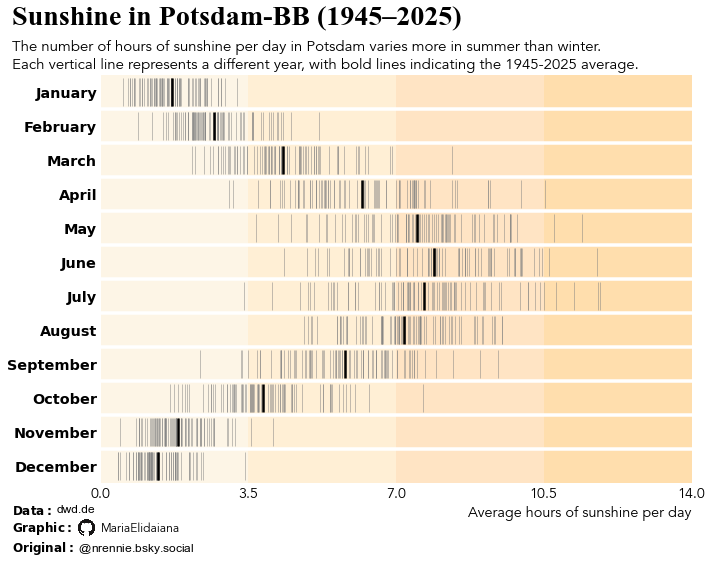

In [21]:
skey5 = 'SD_STRAHL'  
tlabel5 = 'Potsdam-BB (1945–2025)'
toptext5 = """The number of hours of sunshine per day in Potsdam varies more in summer than winter. 
Each vertical line represents a different year, with bold lines indicating the 1945-2025 average."""
savename5 = 'sunshine_postdamBB_1945-2025.png'

sunshine_plot(monthly_means5, climatology5, dkey5, skey5, tlabel5, toptext5, icon, savename5)